# Inicio y carga de datos

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --id 1sjcx1kAsGBZFXOodOVISw0Om1xv4cPfe -O Pump_initial_data.csv

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sjcx1kAsGBZFXOodOVISw0Om1xv4cPfe
To: /content/Pump_initial_data.csv
100% 20.8M/20.8M [00:00<00:00, 144MB/s]


In [ ]:
pumps_df=pd.read_csv("Pump_initial_data.csv", parse_dates=['date_recorded'], date_format='%d/%m/%Y')

In [ ]:
#Opcion de carga local
# pumps_df=pd.read_csv("./data/Pump_initial_data.csv", parse_dates=['date_recorded'], date_format='%d/%m/%Y')

In [ ]:
pumps_df.shape

(59400, 41)

In [ ]:
pumps_df.dtypes

,0
id,int64
amount_tsh,float64
date_recorded,datetime64[ns]
funder,object
gps_height,int64
installer,object
longitude,float64
latitude,float64
wpt_name,object
num_private,int64


# Revisión de datos nulos generales

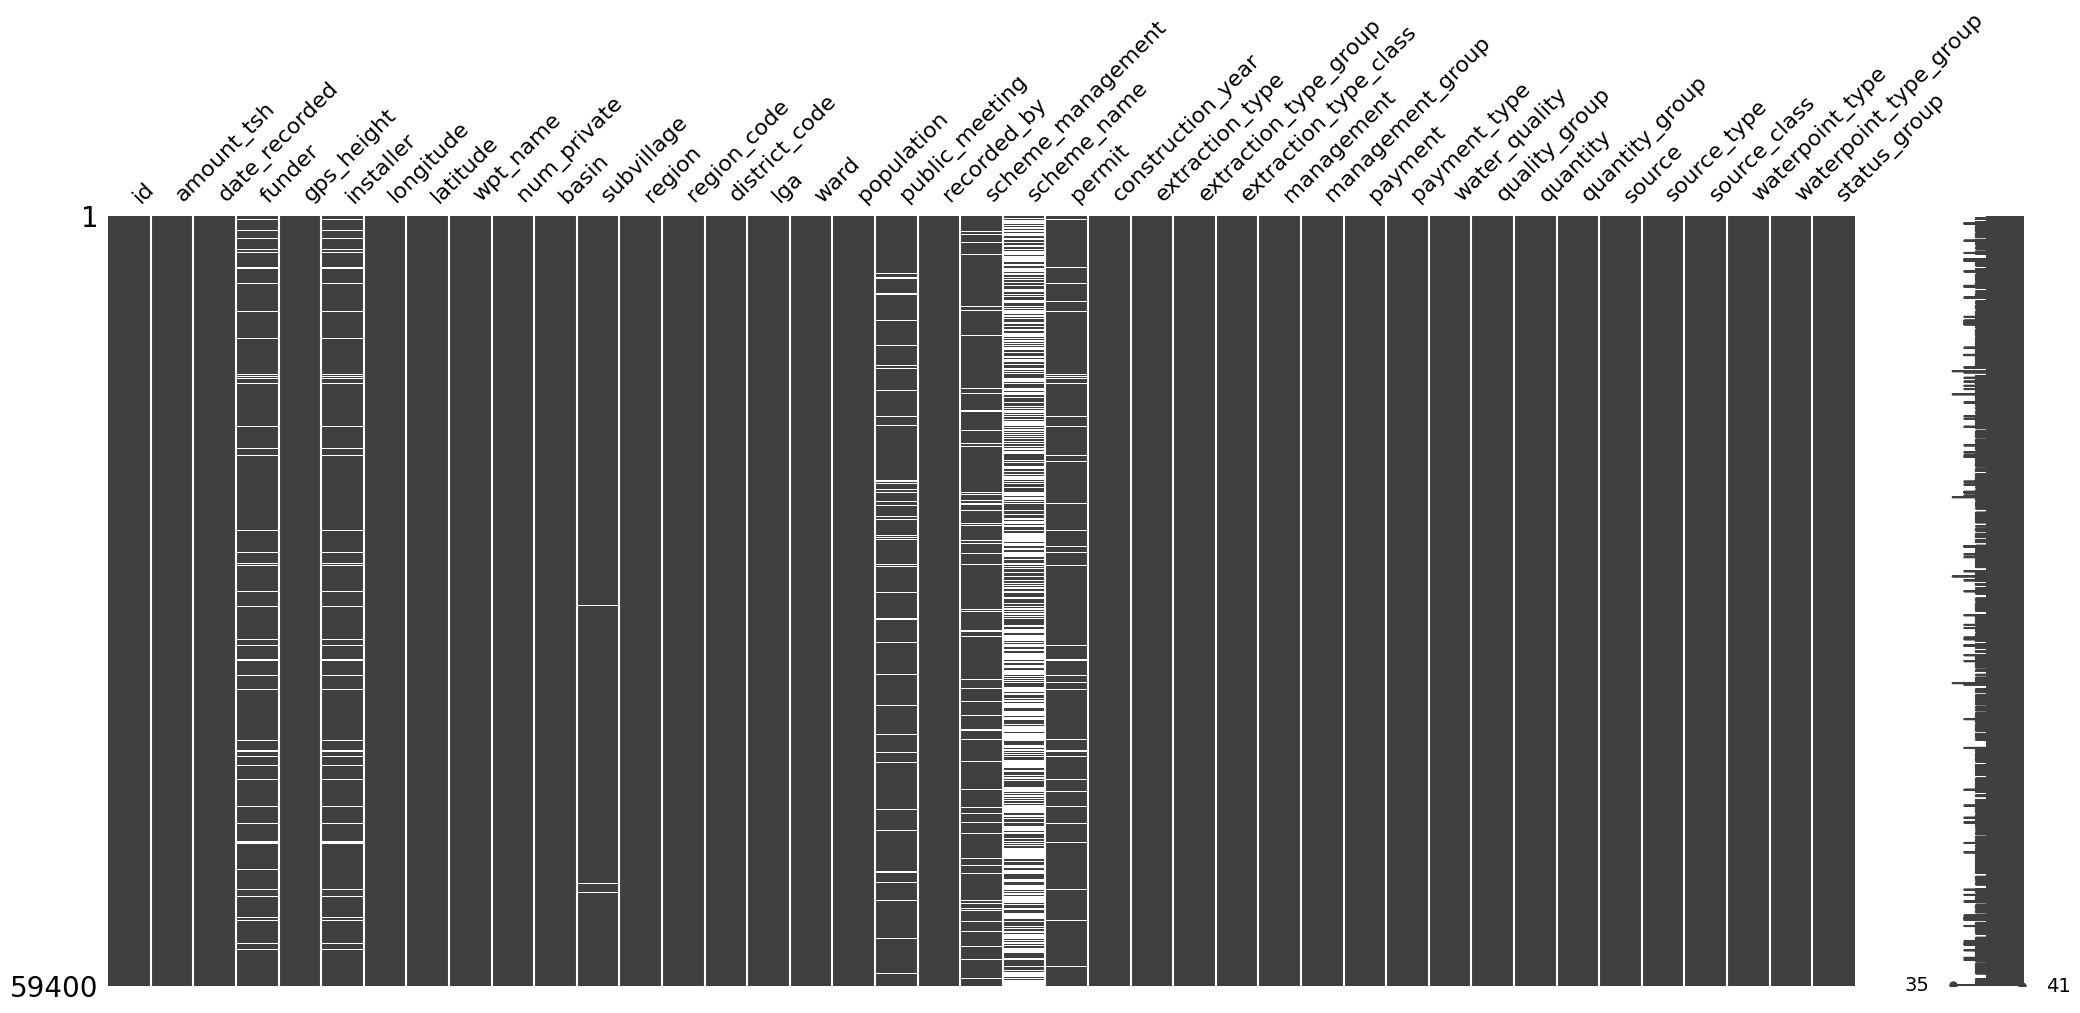

In [ ]:
import missingno as msno

# Visualizar los valores nulos en el DataFrame
msno.matrix(pumps_df)
plt.show()

# Creación Definición de metodos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_categorical_variable(data, category):
    """
    Realiza un análisis univariado detallado para una variable categórica.

    Parámetros:
    data (pd.DataFrame): El DataFrame de entrada.
    category (str): Nombre de la columna categórica a analizar.
    """
    # Paso 1: Información general de la variable
    total_rows = len(data)
    unique_categories = data[category].nunique()
    null_values = data[category].isnull().sum()
    duplicated_rows = data.duplicated().sum()

    print(f"Total de filas: {total_rows}")
    print(f"Valores únicos en '{category}': {unique_categories}")
    print(f"Valores nulos en '{category}': {null_values}")
    print(f"Filas duplicadas: {duplicated_rows}")

    # Paso 2: Distribución de la variable categórica
    value_counts = data[category].value_counts(dropna=False)
    value_counts_pct = data[category].value_counts(normalize=True, dropna=False) * 100

    print("\nDistribución de valores en la categoría:")
    print(pd.DataFrame({'Count': value_counts, 'Percentage': value_counts_pct.round(2)}))

    # Visualización 1: Gráfico de barras de la distribución de categorías
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, y=category, order=value_counts.index, palette="viridis")
    plt.title(f'Distribución de categorías en {category}')
    plt.xlabel('Frecuencia')
    plt.ylabel(category)
    plt.show()

    # Paso 3: Categorías más y menos frecuentes
    top_category = value_counts.idxmax()
    top_category_pct = value_counts_pct.max()
    bottom_category = value_counts.idxmin()
    bottom_category_pct = value_counts_pct.min()

    print(f"\nCategoría más frecuente: '{top_category}' - {top_category_pct:.2f}% del total")
    print(f"Categoría menos frecuente: '{bottom_category}' - {bottom_category_pct:.2f}% del total")

    # Paso 4: Valores nulos y su distribución
    if null_values > 0:
        null_percentage = (null_values / total_rows) * 100
        print(f"\nValores nulos en '{category}': {null_values} ({null_percentage:.2f}%)")

    # Visualización 2: Gráfico de pie de la distribución de categorías (opcional)
    plt.figure(figsize=(8, 8))
    value_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("viridis", len(value_counts)))
    plt.ylabel('')
    plt.title(f"Distribución de categorías en '{category}'")
    plt.show()

    # Resumen del análisis
    summary = {
        "Total Rows": total_rows,
        "Unique Categories": unique_categories,
        "Null Values": null_values,
        "Duplicated Rows": duplicated_rows,
        "Most Frequent Category": top_category,
        "Most Frequent Category Percentage": top_category_pct,
        "Least Frequent Category": bottom_category,
        "Least Frequent Category Percentage": bottom_category_pct
    }

    return summary


In [ ]:


def distribution_checker(data, category):
    # Paso 0: Verificar valores nulos y duplicados
    null_values = data[category].isnull().sum()
    duplicated_rows = data.duplicated().sum()

    print(f"Valores nulos en {category}: {null_values}")
    print(f"Filas duplicadas: {duplicated_rows}")

    # Paso 1: Agrupar datos según la categoría y el estado de las bombas
    count_data = data.groupby([category, 'status_group'])['id'].size().unstack(fill_value=0)

    # Paso 2: Calcular el total de bombas por cada categoría
    count_data['total_pumps'] = count_data.sum(axis=1)

    # Paso 3: Calcular los porcentajes de bombas funcionales, no funcionales y en reparación
    count_data['pct_functional'] = (count_data['functional'] / count_data['total_pumps'] * 100).round(2)
    count_data['pct_needs_repair'] = (count_data['functional needs repair'] / count_data['total_pumps'] * 100).round(2)
    count_data['pct_non_functional'] = (count_data['non functional'] / count_data['total_pumps'] * 100).round(2)

    # Paso 4: Eliminar las columnas de conteo directo (opcional)
    count_data = count_data.drop(columns=['functional', 'functional needs repair', 'non functional'])

    # Paso 5: Calcular el porcentaje de cada categoría sobre el total general
    total_all_pumps = count_data['total_pumps'].sum()
    count_data['pct_of_total'] = (count_data['total_pumps'] / total_all_pumps * 100).round(2)


    custom_colors = {
        "functional": "#adf7b6",   # Verde pastel
        "functional needs repair": "#ffee93", # Amarillo pastel
        "non functional": "#f68c70"  # Rojo pastel
    }

    # Crear el gráfico de barras apiladas
    count_data[['pct_functional', 'pct_needs_repair', 'pct_non_functional']].plot(
    kind='bar',
    stacked=True,
    color=[custom_colors["functional"], custom_colors["functional needs repair"], custom_colors["non functional"]],
    figsize=(10, 6)
    )

    # Personalizar el gráfico
    plt.title(f'Distribución de estados por {category}', fontsize=16)
    plt.xlabel(f'Subcategorías de {category}', fontsize=14)
    plt.ylabel('Porcentaje (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(['Funcional', 'Necesita Reparación', 'No Funcional'], loc='upper right')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

    return count_data




# Analisis Univariado

## QUALITY GROUP

Total de filas: 59400
Valores únicos en 'quality_group': 6
Valores nulos en 'quality_group': 0
Filas duplicadas: 0

Distribución de valores en la categoría:
               Count  Percentage
quality_group                   
good           50818       85.55
salty           5195        8.75
unknown         1876        3.16
milky            804        1.35
colored          490        0.82
fluoride         217        0.37


<ipython-input-11-5a27f5866952>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, y=category, order=value_counts.index, palette="viridis")


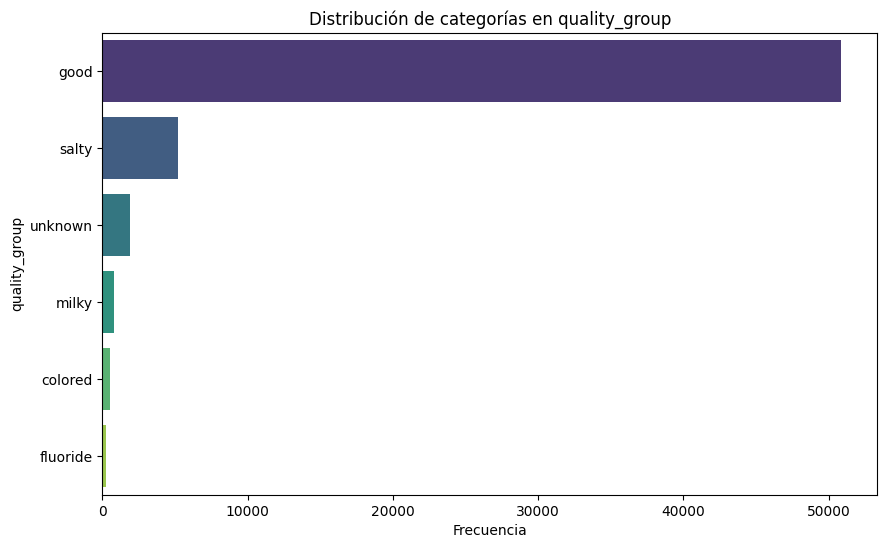


Categoría más frecuente: 'good' - 85.55% del total
Categoría menos frecuente: 'fluoride' - 0.37% del total


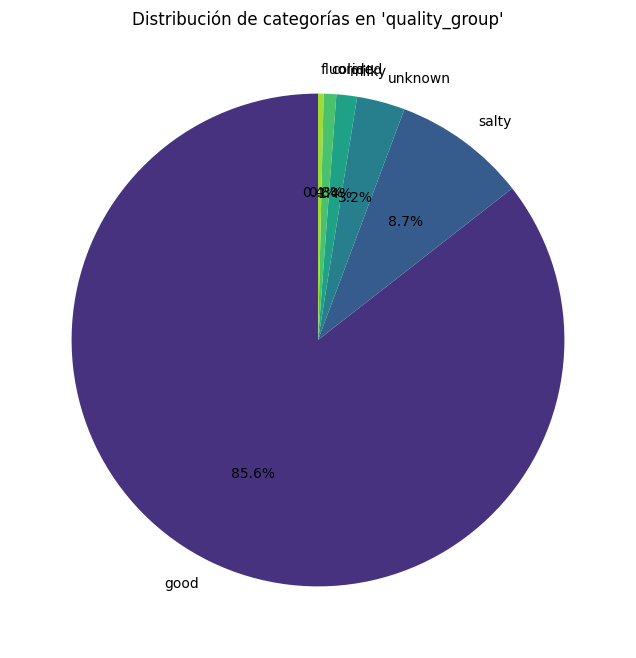

{'Total Rows': 59400,
 'Unique Categories': 6,
 'Null Values': 0,
 'Duplicated Rows': 0,
 'Most Frequent Category': 'good',
 'Most Frequent Category Percentage': 85.55218855218855,
 'Least Frequent Category': 'fluoride',
 'Least Frequent Category Percentage': 0.3653198653198653}

In [ ]:
analyze_categorical_variable(pumps_df, 'quality_group')


Existen 6  grupos de calidades del agua dentro de las minas. La mayoría de las bombas tienen una buena calidad de agua con un 85%. La presencia de flúor, salinidad y turbidez son indicadores de una mala calidad del agua.

No tiene nulos, pero si 1876 de categoria unkwown.

## Water Quality

Total de filas: 59400
Valores únicos en 'water_quality': 8
Valores nulos en 'water_quality': 0
Filas duplicadas: 0

Distribución de valores en la categoría:
                    Count  Percentage
water_quality                        
soft                50818       85.55
salty                4856        8.18
unknown              1876        3.16
milky                 804        1.35
coloured              490        0.82
salty abandoned       339        0.57
fluoride              200        0.34
fluoride abandoned     17        0.03


<ipython-input-11-5a27f5866952>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, y=category, order=value_counts.index, palette="viridis")


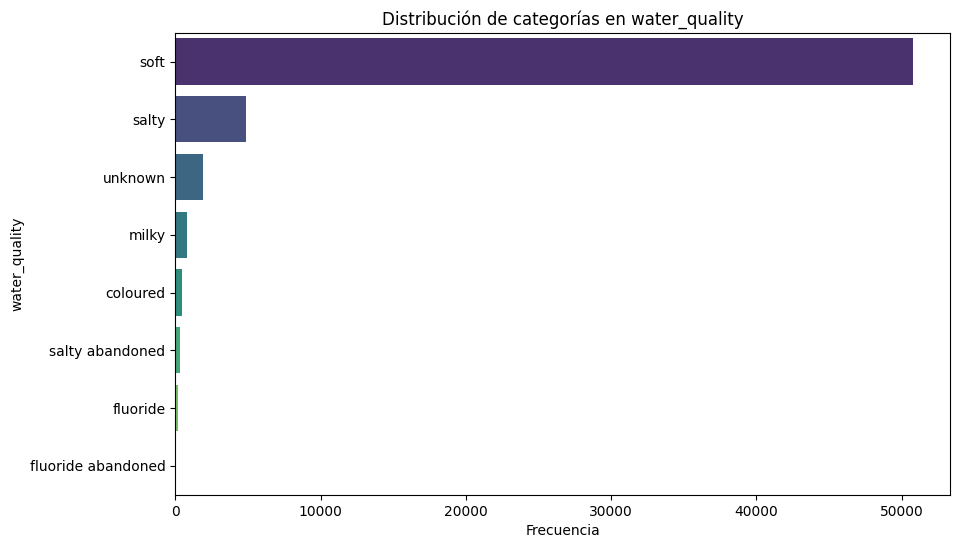


Categoría más frecuente: 'soft' - 85.55% del total
Categoría menos frecuente: 'fluoride abandoned' - 0.03% del total


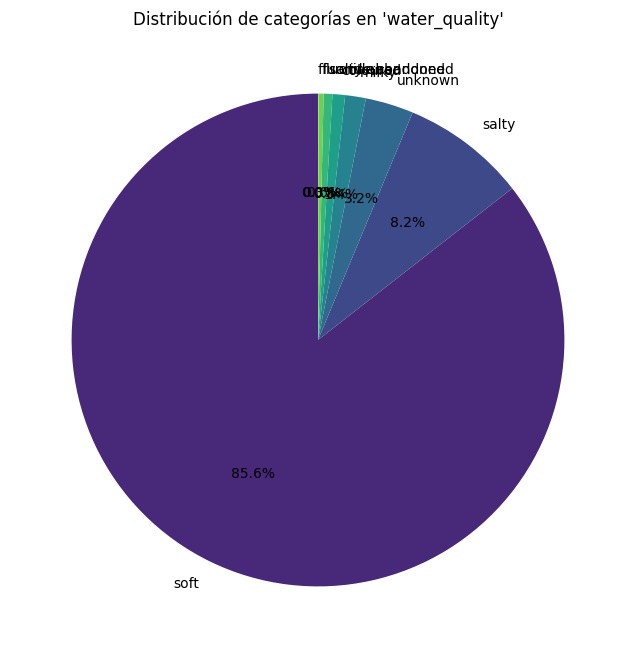

{'Total Rows': 59400,
 'Unique Categories': 8,
 'Null Values': 0,
 'Duplicated Rows': 0,
 'Most Frequent Category': 'soft',
 'Most Frequent Category Percentage': 85.55218855218855,
 'Least Frequent Category': 'fluoride abandoned',
 'Least Frequent Category Percentage': 0.02861952861952862}

In [ ]:
analyze_categorical_variable(pumps_df, 'water_quality')


La variable water_quality en el conjunto de 59,400 registros no tiene valores nulos ni duplicados, con una distribución dominada por el agua "soft" (85.55%). Los tipos "salty" (8.18%) y "unknown" (3.16%) son menos frecuentes, y otras categorías como "milky" y "coloured" están por debajo del 2%. Esta alta proporción de agua blanda sugiere una predominancia en la calidad, mientras que las otras categorías pueden indicar condiciones específicas en ciertos pozos.

## Quantity Group



Total de filas: 59400
Valores únicos en 'quantity_group': 5
Valores nulos en 'quantity_group': 0
Filas duplicadas: 0

Distribución de valores en la categoría:
                Count  Percentage
quantity_group                   
enough          33186       55.87
insufficient    15129       25.47
dry              6246       10.52
seasonal         4050        6.82
unknown           789        1.33


<ipython-input-11-5a27f5866952>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, y=category, order=value_counts.index, palette="viridis")


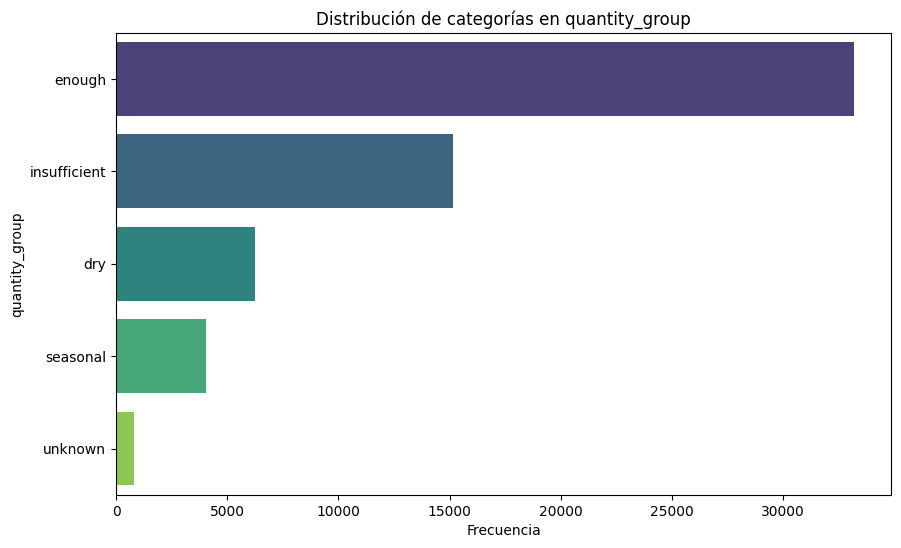


Categoría más frecuente: 'enough' - 55.87% del total
Categoría menos frecuente: 'unknown' - 1.33% del total


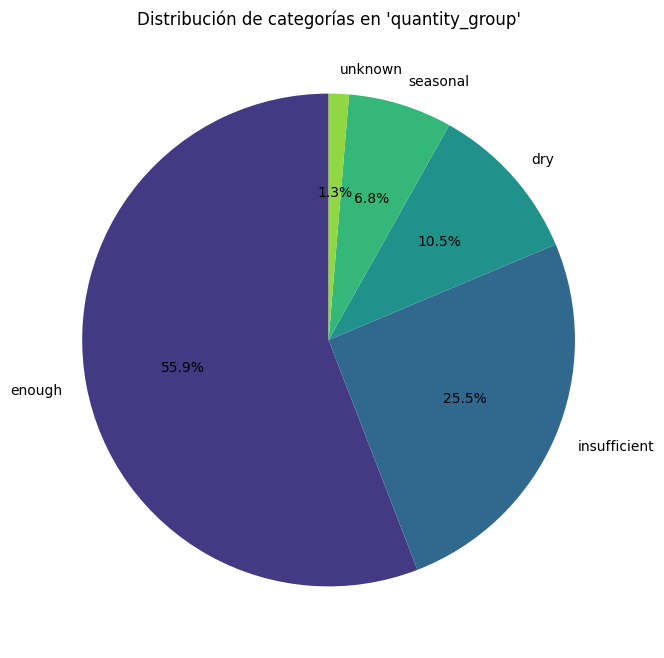

{'Total Rows': 59400,
 'Unique Categories': 5,
 'Null Values': 0,
 'Duplicated Rows': 0,
 'Most Frequent Category': 'enough',
 'Most Frequent Category Percentage': 55.868686868686865,
 'Least Frequent Category': 'unknown',
 'Least Frequent Category Percentage': 1.3282828282828283}

In [ ]:
analyze_categorical_variable(pumps_df, 'quantity_group')


## Quantity

Total de filas: 59400
Valores únicos en 'quantity': 5
Valores nulos en 'quantity': 0
Filas duplicadas: 0

Distribución de valores en la categoría:
              Count  Percentage
quantity                       
enough        33186       55.87
insufficient  15129       25.47
dry            6246       10.52
seasonal       4050        6.82
unknown         789        1.33


<ipython-input-11-5a27f5866952>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, y=category, order=value_counts.index, palette="viridis")


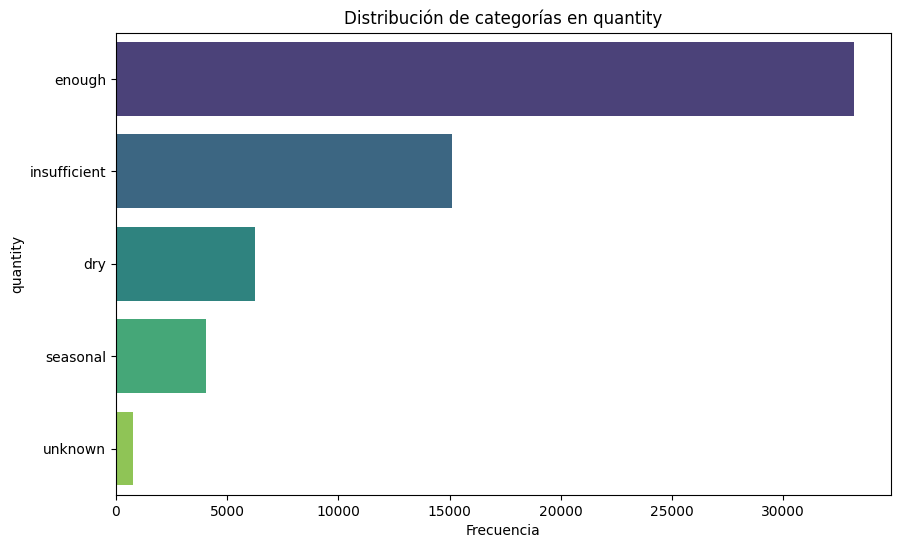


Categoría más frecuente: 'enough' - 55.87% del total
Categoría menos frecuente: 'unknown' - 1.33% del total


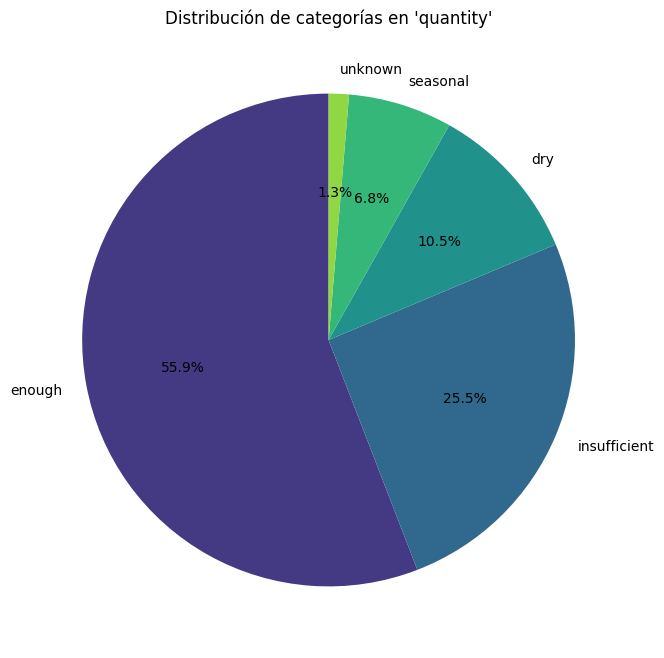

{'Total Rows': 59400,
 'Unique Categories': 5,
 'Null Values': 0,
 'Duplicated Rows': 0,
 'Most Frequent Category': 'enough',
 'Most Frequent Category Percentage': 55.868686868686865,
 'Least Frequent Category': 'unknown',
 'Least Frequent Category Percentage': 1.3282828282828283}

In [ ]:
analyze_categorical_variable(pumps_df, 'quantity')


La variable quantity en el conjunto de datos de 59,400 registros no contiene valores nulos ni duplicados. La distribución muestra que el 55.87% de los pozos tienen una cantidad de agua "enough," mientras que el 25.47% es "insufficient" y el 10.52% están "dry." Las categorías "seasonal" y "unknown" representan una menor proporción (6.82% y 1.33%, respectivamente), destacando una predominancia de pozos con suficiente agua, aunque un cuarto presenta insuficiencia, lo que puede indicar áreas con problemas de disponibilidad de agua.

## Source class


Total de filas: 59400
Valores únicos en 'source_class': 3
Valores nulos en 'source_class': 0
Filas duplicadas: 0

Distribución de valores en la categoría:
              Count  Percentage
source_class                   
groundwater   45794       77.09
surface       13328       22.44
unknown         278        0.47


<ipython-input-11-5a27f5866952>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, y=category, order=value_counts.index, palette="viridis")


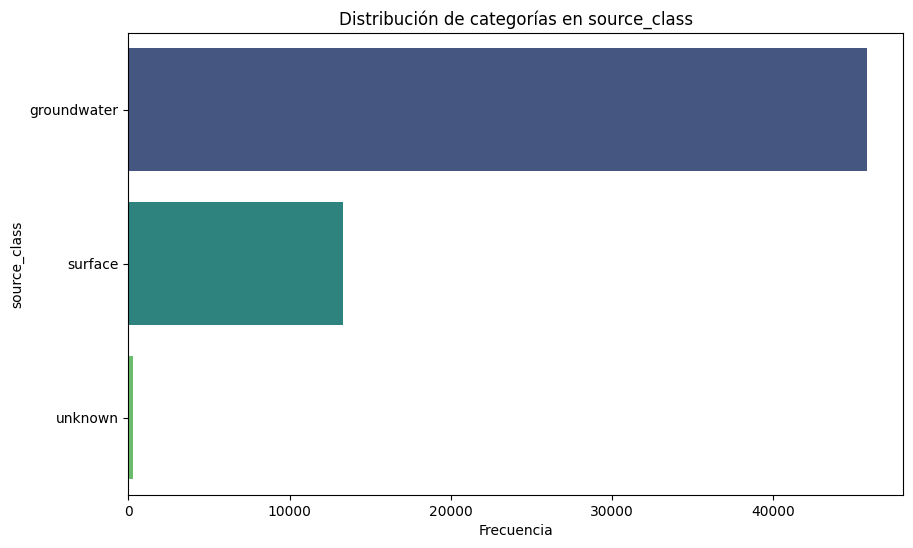


Categoría más frecuente: 'groundwater' - 77.09% del total
Categoría menos frecuente: 'unknown' - 0.47% del total


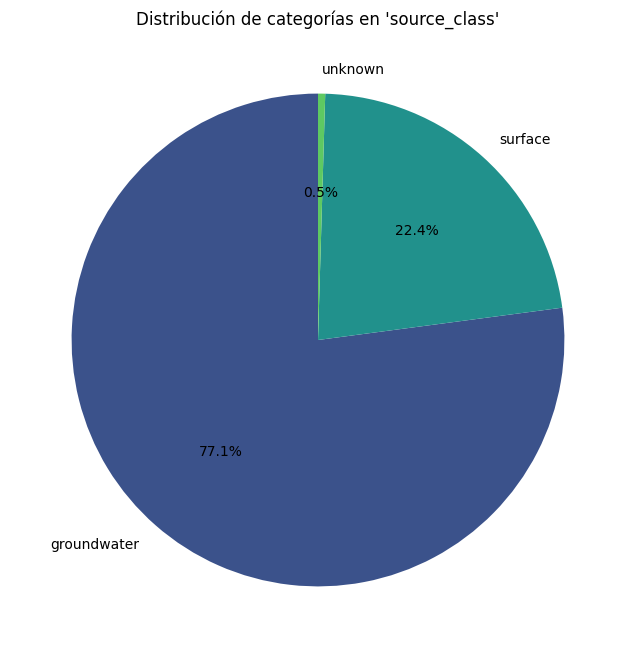

{'Total Rows': 59400,
 'Unique Categories': 3,
 'Null Values': 0,
 'Duplicated Rows': 0,
 'Most Frequent Category': 'groundwater',
 'Most Frequent Category Percentage': 77.0942760942761,
 'Least Frequent Category': 'unknown',
 'Least Frequent Category Percentage': 0.468013468013468}

In [ ]:
analyze_categorical_variable(pumps_df, 'source_class')


La variable source_class en el conjunto de 59,400 registros no presenta valores nulos ni duplicados, y se divide en tres categorías principales: el 77.09% corresponde a pozos de "groundwater," el 22.44% a "surface," y un pequeño 0.47% a "unknown." Esto indica que la mayoría de los recursos hídricos provienen de fuentes subterráneas, mientras que una menor proporción se abastece de agua superficial, resaltando la importancia de la gestión sostenible de aguas subterráneas.

## Source Type

Total de filas: 59400
Valores únicos en 'source_type': 7
Valores nulos en 'source_type': 0
Filas duplicadas: 0

Distribución de valores en la categoría:
                      Count  Percentage
source_type                            
spring                17021       28.65
shallow well          16824       28.32
borehole              11949       20.12
river/lake            10377       17.47
rainwater harvesting   2295        3.86
dam                     656        1.10
other                   278        0.47


<ipython-input-11-5a27f5866952>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, y=category, order=value_counts.index, palette="viridis")


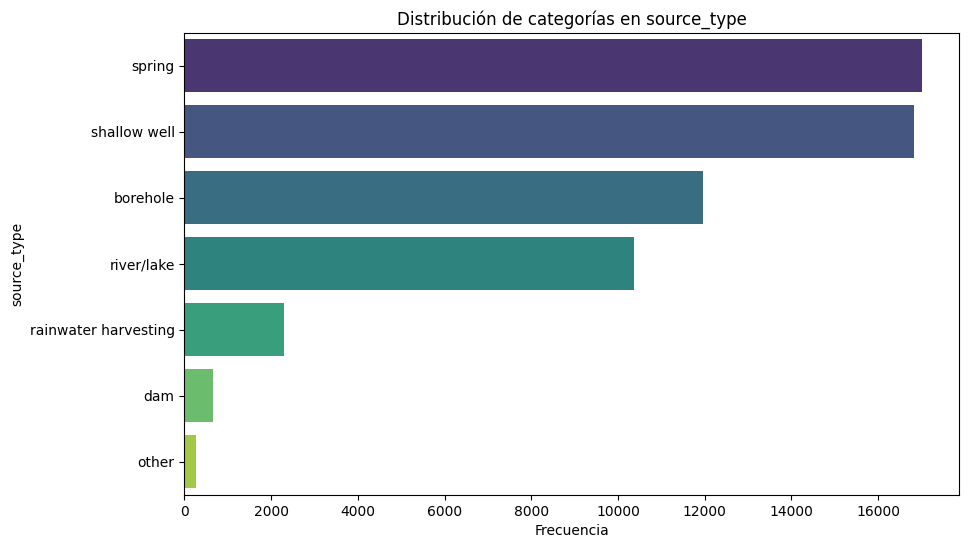


Categoría más frecuente: 'spring' - 28.65% del total
Categoría menos frecuente: 'other' - 0.47% del total


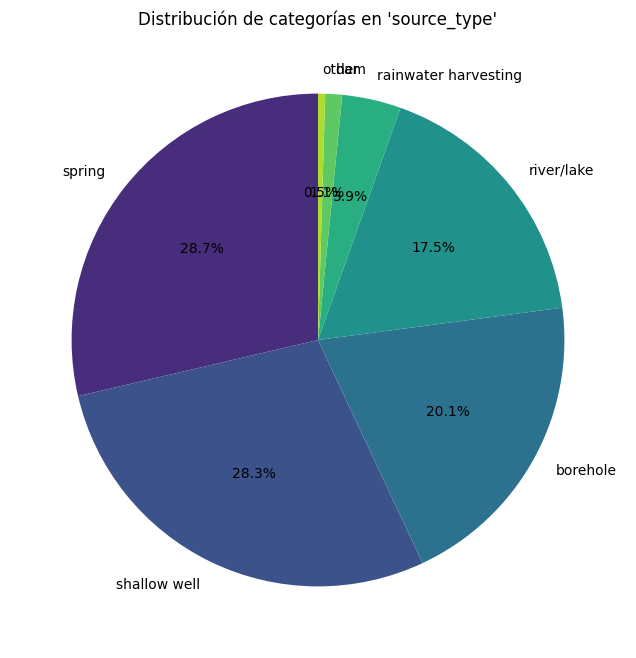

{'Total Rows': 59400,
 'Unique Categories': 7,
 'Null Values': 0,
 'Duplicated Rows': 0,
 'Most Frequent Category': 'spring',
 'Most Frequent Category Percentage': 28.654882154882156,
 'Least Frequent Category': 'other',
 'Least Frequent Category Percentage': 0.468013468013468}

In [ ]:
analyze_categorical_variable(pumps_df, 'source_type')



En la variable source_type, dentro de las 59,400 observaciones y sin valores nulos ni duplicados, destacan tres tipos principales: "spring" (28.65%), "shallow well" (28.32%) y "borehole" (20.12%), que en conjunto cubren más del 77% de los registros. Tipos menos comunes incluyen "river/lake" (17.47%), y categorías minoritarias como "rainwater harvesting" (3.86%) y "dam" (1.10%). Esta distribución sugiere una alta dependencia de fuentes subterráneas y pozos poco profundos para abastecimiento de agua.

## Source

Total de filas: 59400
Valores únicos en 'source': 10
Valores nulos en 'source': 0
Filas duplicadas: 0

Distribución de valores en la categoría:
                      Count  Percentage
source                                 
spring                17021       28.65
shallow well          16824       28.32
machine dbh           11075       18.64
river                  9612       16.18
rainwater harvesting   2295        3.86
hand dtw                874        1.47
lake                    765        1.29
dam                     656        1.10
other                   212        0.36
unknown                  66        0.11


<ipython-input-11-5a27f5866952>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, y=category, order=value_counts.index, palette="viridis")


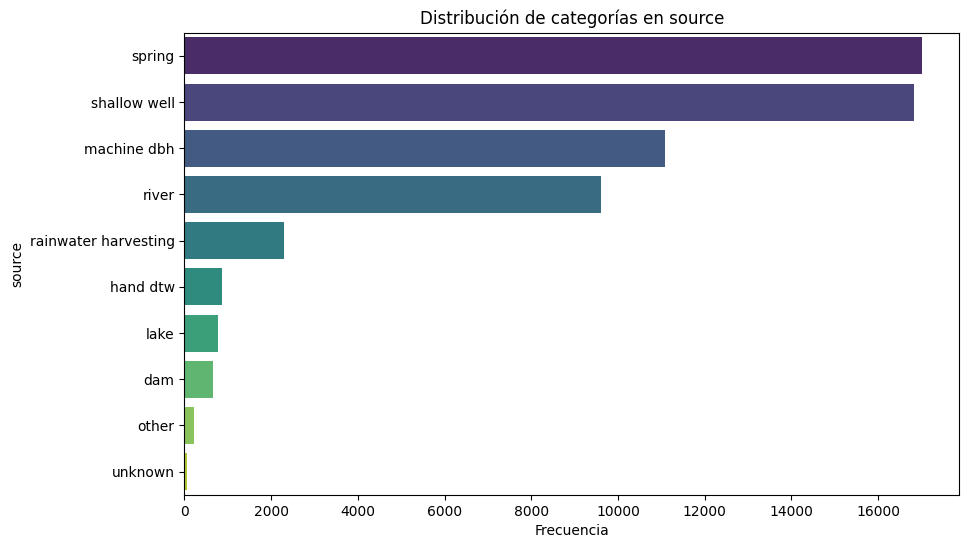


Categoría más frecuente: 'spring' - 28.65% del total
Categoría menos frecuente: 'unknown' - 0.11% del total


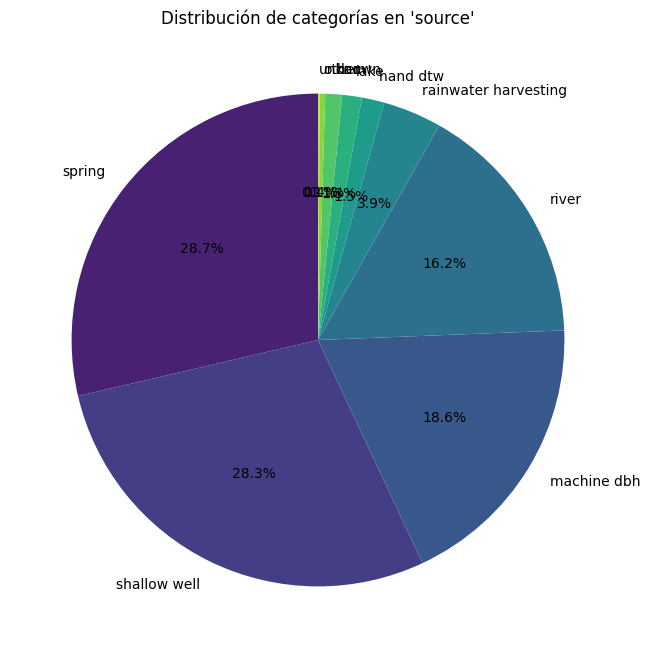

{'Total Rows': 59400,
 'Unique Categories': 10,
 'Null Values': 0,
 'Duplicated Rows': 0,
 'Most Frequent Category': 'spring',
 'Most Frequent Category Percentage': 28.654882154882156,
 'Least Frequent Category': 'unknown',
 'Least Frequent Category Percentage': 0.1111111111111111}

In [ ]:
analyze_categorical_variable(pumps_df, 'source')


En la variable source, de un total de 59,400 registros sin valores nulos ni duplicados, los tipos predominantes son "spring" (28.65%), "shallow well" (28.32%) y "machine dbh" (18.64%), los cuales representan la mayoría de las fuentes de agua. "River" también es común, con un 16.18%, mientras que otras categorías como "rainwater harvesting" (3.86%) y "lake" (1.29%) tienen menor presencia. Esta distribución evidencia una preferencia por fuentes naturales y pozos como principales abastecedores de agua.

## Water Point Type

Total de filas: 59400
Valores únicos en 'waterpoint_type': 7
Valores nulos en 'waterpoint_type': 0
Filas duplicadas: 0

Distribución de valores en la categoría:
                             Count  Percentage
waterpoint_type                               
communal standpipe           28522       48.02
hand pump                    17488       29.44
other                         6380       10.74
communal standpipe multiple   6103       10.27
improved spring                784        1.32
cattle trough                  116        0.20
dam                              7        0.01


<ipython-input-11-5a27f5866952>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, y=category, order=value_counts.index, palette="viridis")


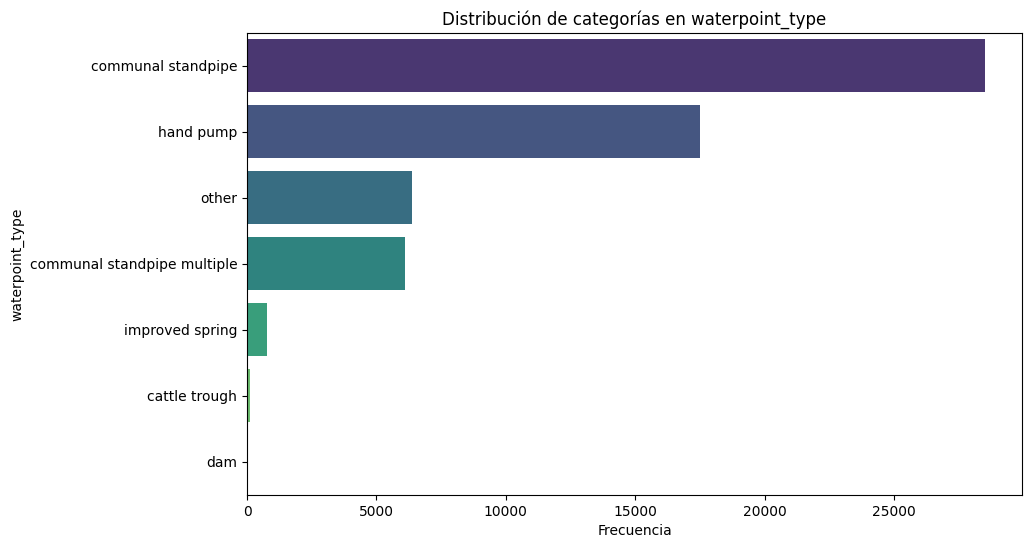


Categoría más frecuente: 'communal standpipe' - 48.02% del total
Categoría menos frecuente: 'dam' - 0.01% del total


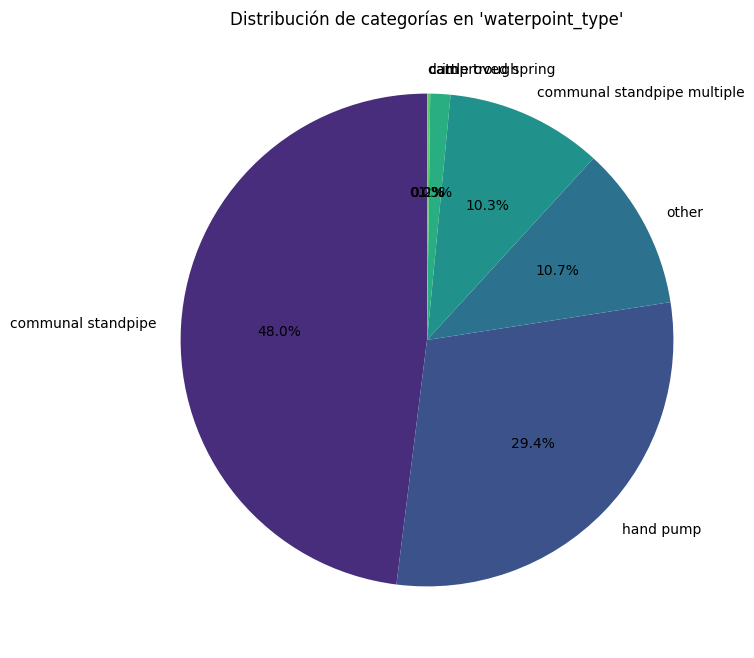

{'Total Rows': 59400,
 'Unique Categories': 7,
 'Null Values': 0,
 'Duplicated Rows': 0,
 'Most Frequent Category': 'communal standpipe',
 'Most Frequent Category Percentage': 48.01683501683502,
 'Least Frequent Category': 'dam',
 'Least Frequent Category Percentage': 0.011784511784511785}

In [ ]:
analyze_categorical_variable(pumps_df, 'waterpoint_type')


In [ ]:
waterpoint_type = distribution_checker(pumps_df, 'waterpoint_type_group')
waterpoint_type = waterpoint_type .sort_values('total_pumps', ascending= False)
waterpoint_type .head(10)

,nr_pumps,%_pumps,%_functional,%_non_functional,%_functional_but_repair
waterpoint_type_group,,,,,
communal standpipe,34625.0,58.3,57.6,34.0,8.4
hand pump,17488.0,29.4,61.8,32.3,5.9
other,6380.0,10.7,13.2,82.2,4.6
improved spring,784.0,1.3,71.8,17.3,10.8
cattle trough,116.0,0.2,72.4,25.9,1.7
dam,7.0,0.0,85.7,14.3,0.0


waterpoint_type y su groups dan información muy similar. Es mejor mantenerla desagregada. En ese sentido optaremos por mantenerla waterpoint_type nada mas.

# ANALISIS MULTIVARIADO


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import chi2_contingency
import random

def multivariate_analysis(data, cat_var1, cat_var2):
    # Paso 0: Verificar valores nulos
    nulls_var1 = data[cat_var1].isnull().sum()
    nulls_var2 = data[cat_var2].isnull().sum()
    print(f"Valores nulos en {cat_var1}: {nulls_var1}")
    print(f"Valores nulos en {cat_var2}: {nulls_var2}")

    # Paso 1: Tabla de contingencia con scroll horizontal
    pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
    pd.set_option('display.expand_frame_repr', False)  # Evitar el corte horizontal en la impresión
    contingency_table = pd.crosstab(data[cat_var1], data[cat_var2], margins=True, margins_name="Total")
    print(f"\nTabla de contingencia entre {cat_var1} y {cat_var2}:")
    print(contingency_table)

    # Paso 2: Calcular los porcentajes para cada categoría
    print(f"\nPorcentaje de {cat_var2} dentro de cada {cat_var1}:")
    percent_table = pd.crosstab(data[cat_var1], data[cat_var2], normalize='index') * 100
    print(percent_table.round(2))

    # Definir colores personalizados para categorías específicas
    custom_colors = {
        "functional": "#adf7b6",   # Verde pastel
        "functional needs repair": "#ffee93", # Amarillo pastel
        "non functional": "#f68c70"  # Rojo pastel
    }

    # Si hay categorías adicionales, utilizamos colores pastel de una paleta predefinida
    pastel_palette = plt.get_cmap('Pastel1').colors  # Usamos la paleta Pastel1 de Matplotlib
    random_colors = random.sample(pastel_palette, len(percent_table.columns))  # Selecciona colores aleatorios

    # Asignar colores: si está en custom_colors usa ese, si no, uno aleatorio
    colors = [custom_colors.get(col, random.choice(random_colors)) for col in percent_table.columns]

    # Paso 3: Gráfico de barras apiladas con colores personalizados y porcentajes
    plt.figure(figsize=(10, 6))

    # Crear gráfico de barras apiladas
    ax = percent_table.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))

    # Añadir los porcentajes encima de las barras
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.1f%%', label_type='center', fontsize=10)

    # Personalizar gráfico
    plt.title(f'Relación entre {cat_var1} y {cat_var2}', fontsize=16)
    plt.xlabel(cat_var1, fontsize=14)
    plt.ylabel('Porcentaje (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title=cat_var2, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

    # Paso 4: Calcular métricas adicionales
    unique_var1 = data[cat_var1].nunique()
    unique_var2 = data[cat_var2].nunique()
    print(f"\nValores únicos en {cat_var1}: {unique_var1}")
    print(f"Valores únicos en {cat_var2}: {unique_var2}")

    most_frequent_var1 = data[cat_var1].mode()[0]
    most_frequent_var2 = data[cat_var2].mode()[0]
    print(f"Valor más frecuente en {cat_var1}: {most_frequent_var1}")
    print(f"Valor más frecuente en {cat_var2}: {most_frequent_var2}")

    # Paso 5: Análisis de chi-cuadrado
    chi2, p, dof, expected = chi2_contingency(pd.crosstab(data[cat_var1], data[cat_var2]))

    print(f"\nResultado del análisis chi-cuadrado:")
    print(f"Chi-cuadrado: {chi2:.4f}")
    print(f"P-valor: {p:.4f}")
    print(f"Grados de libertad: {dof}")

    # Interpretación del p-valor
    alpha = 0.05  # Nivel de significancia común
    if p < alpha:
        print(f"El p-valor es menor que {alpha}, por lo que rechazamos la hipótesis nula. "
              f"Esto indica que {cat_var1} y {cat_var2} están correlacionadas.")
    else:
        print(f"El p-valor es mayor que {alpha}, por lo que no podemos rechazar la hipótesis nula. "
              f"Esto indica que {cat_var1} y {cat_var2} no están correlacionadas.")



```
status_group,quality_group
```


Valores nulos en quality_group: 0
Valores nulos en status_group: 0

Tabla de contingencia entre quality_group y status_group:
status_group   functional  functional needs repair  non functional  Total
quality_group                                                            
colored               246                       54             190    490
fluoride              157                       13              47    217
good                28760                     3904           18154  50818
milky                 438                       14             352    804
salty                2394                      297            2504   5195
unknown               264                       35            1577   1876
Total               32259                     4317           22824  59400

Porcentaje de status_group dentro de cada quality_group:
status_group   functional  functional needs repair  non functional
quality_group                                                     
colored         

<Figure size 1000x600 with 0 Axes>

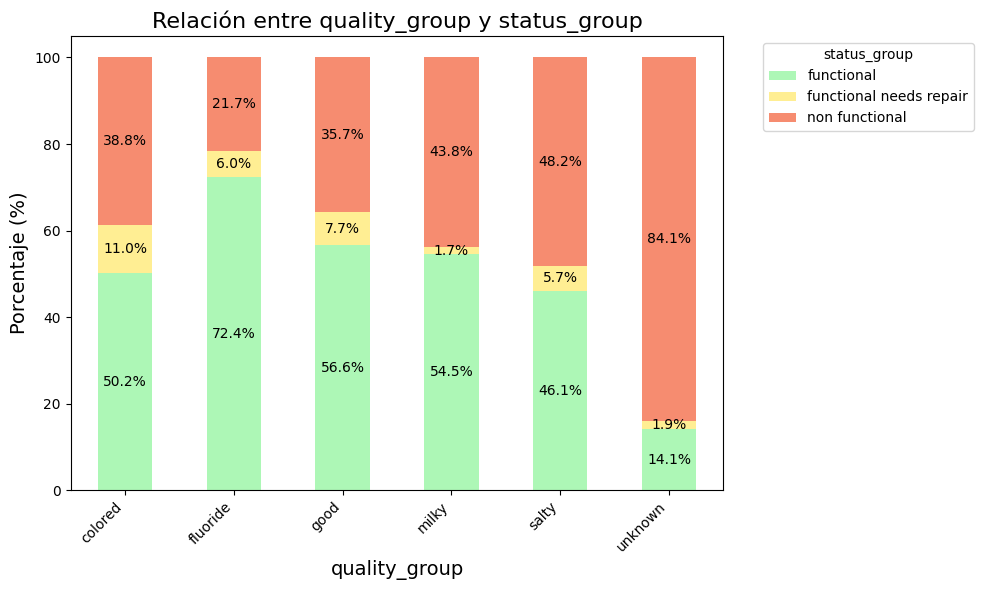


Valores únicos en quality_group: 6
Valores únicos en status_group: 3
Valor más frecuente en quality_group: good
Valor más frecuente en status_group: functional

Resultado del análisis chi-cuadrado:
Chi-cuadrado: 2100.1366
P-valor: 0.0000
Grados de libertad: 10
El p-valor es menor que 0.05, por lo que rechazamos la hipótesis nula. Esto indica que quality_group y status_group están correlacionadas.


In [ ]:
multivariate_analysis(pumps_df,"quality_group","status_group" )

La calidad de agua good está asociada en gran medida con bombas funcionales, pero no garantiza su buen estado, ya que también está presente en las bombas no funcionales.

Las categorías de calidad salty y unknown pueden ser buenos indicadores de posibles problemas o fallos en las bombas, ya que tienen una mayor proporción dentro de las bombas no funcionales.

El hecho de que algunas bombas funcionales presenten categorías como colored, milky o **salty** sugiere que no todas las bombas con agua de estas calidades están defectuosas, pero requieren un seguimiento más cercano.


```
status_group,quantity_group
```


Valores nulos en quantity_group: 0
Valores nulos en status_group: 0

Tabla de contingencia entre quantity_group y status_group:
status_group    functional  functional needs repair  non functional  Total
quantity_group                                                            
dry                    157                       37            6052   6246
enough               21648                     2400            9138  33186
insufficient          7916                     1450            5763  15129
seasonal              2325                      416            1309   4050
unknown                213                       14             562    789
Total                32259                     4317           22824  59400

Porcentaje de status_group dentro de cada quantity_group:
status_group    functional  functional needs repair  non functional
quantity_group                                                     
dry                   2.51                     0.59           96.89
enough   

<Figure size 1000x600 with 0 Axes>

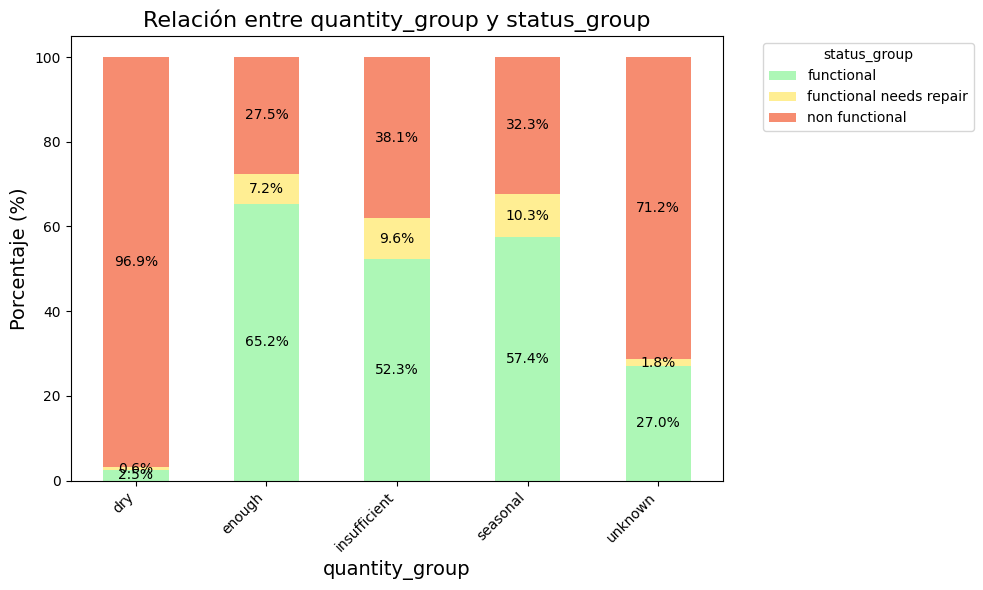


Valores únicos en quantity_group: 5
Valores únicos en status_group: 3
Valor más frecuente en quantity_group: enough
Valor más frecuente en status_group: functional

Resultado del análisis chi-cuadrado:
Chi-cuadrado: 11360.7679
P-valor: 0.0000
Grados de libertad: 8
El p-valor es menor que 0.05, por lo que rechazamos la hipótesis nula. Esto indica que quantity_group y status_group están correlacionadas.


In [ ]:
multivariate_analysis(pumps_df,"quantity_group" ,"status_group")

Las bombas con suficiente agua (enough) tienden a estar funcionales, mientras que una proporción significativa de las bombas sin agua (dry) son no funcionales.

La falta de agua (dry) es un fuerte indicador de problemas, ya que una cuarta parte de las bombas no funcionales pertenecen a esta categoría.

Las bombas que tienen cantidades insuficientes de agua presentan un mayor riesgo de necesitar reparación o estar no funcionales.

Las bombas estacionales (con acceso a agua solo en ciertas épocas) también muestran una tendencia a estar en mal estado, aunque representan una fracción menor del total.


```
status_group,source
```


Valores nulos en source: 0
Valores nulos en status_group: 0

Tabla de contingencia entre source y status_group:
status_group          functional  functional needs repair  non functional  Total
source                                                                          
dam                          253                       24             379    656
hand dtw                     497                       17             360    874
lake                         162                       12             591    765
machine dbh                 5422                      491            5162  11075
other                        126                        1              85    212
rainwater harvesting        1386                      314             595   2295
river                       5465                     1221            2926   9612
shallow well                8324                      957            7543  16824
spring                     10592                     1276            5153  170

<Figure size 1000x600 with 0 Axes>

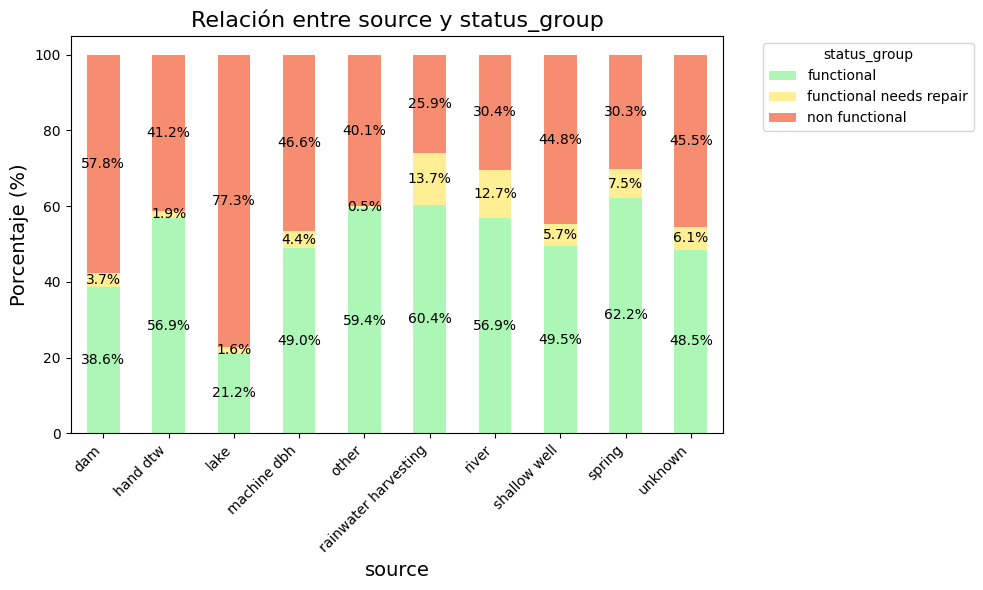


Valores únicos en source: 10
Valores únicos en status_group: 3
Valor más frecuente en source: spring
Valor más frecuente en status_group: functional

Resultado del análisis chi-cuadrado:
Chi-cuadrado: 2623.9983
P-valor: 0.0000
Grados de libertad: 18
El p-valor es menor que 0.05, por lo que rechazamos la hipótesis nula. Esto indica que source y status_group están correlacionadas.


In [ ]:
multivariate_analysis(pumps_df,"source","status_group" )

Las bombas que operan con fuentes como machine dbh (bomba mecánica) y dam (represa) tienen una mayor tendencia a estar no funcionales. Esto podría fallos en la maquinaria por su uso.


```
status_group,waterpoint_type
```


Valores nulos en waterpoint_type: 0
Valores nulos en status_group: 0

Tabla de contingencia entre waterpoint_type y status_group:
status_group                 functional  functional needs repair  non functional  Total
waterpoint_type                                                                        
cattle trough                        84                        2              30    116
communal standpipe                17726                     2260            8536  28522
communal standpipe multiple        2235                      648            3220   6103
dam                                   6                        0               1      7
hand pump                         10805                     1029            5654  17488
improved spring                     563                       85             136    784
other                               840                      293            5247   6380
Total                             32259                     4317           228

<Figure size 1000x600 with 0 Axes>

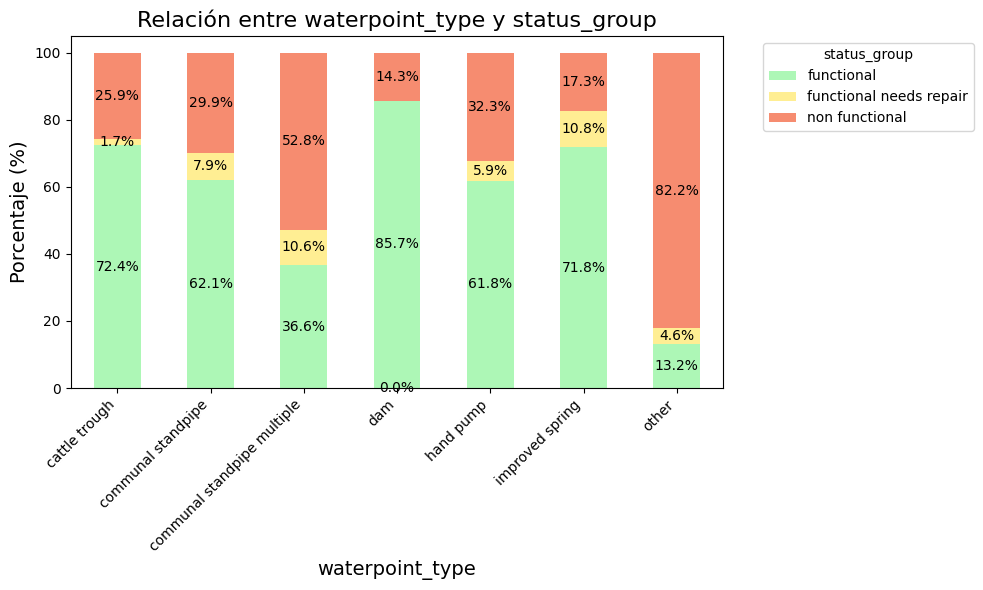


Valores únicos en waterpoint_type: 7
Valores únicos en status_group: 3
Valor más frecuente en waterpoint_type: communal standpipe
Valor más frecuente en status_group: functional

Resultado del análisis chi-cuadrado:
Chi-cuadrado: 7450.3166
P-valor: 0.0000
Grados de libertad: 12
El p-valor es menor que 0.05, por lo que rechazamos la hipótesis nula. Esto indica que waterpoint_type y status_group están correlacionadas.


In [ ]:
multivariate_analysis(pumps_df,"waterpoint_type" ,"status_group")

Los grifos comunitarios (communal standpipe) son el tipo de punto de agua más común tanto para bombas funcionales como no funcionales, pero hay una diferencia notable en la proporción de bombas funcionales (54.95%) versus no funcionales (37.40%). Esto podría señalar problemas recurrentes en este tipo de instalaciones.

Los puntos de agua clasificados como "other" tienen una alta probabilidad de no funcionar, representando el 22.99% de los puntos no funcionales, lo que sugiere que se debe prestar atención a qué tipo de infraestructuras se agrupan bajo esta categoría.


```
extraction_type_class ,waterpoint_type
```


Valores nulos en extraction_type_class: 0
Valores nulos en waterpoint_type: 0

Tabla de contingencia entre extraction_type_class y waterpoint_type:
waterpoint_type        cattle trough  communal standpipe  communal standpipe multiple  dam  hand pump  improved spring  other  Total
extraction_type_class                                                                                                               
gravity                           96               22121                         2657    2         75              632   1197  26780
handpump                           0                  81                            7    0      16283                1     84  16456
motorpump                          1                1560                         1291    0         22                0    113   2987
other                              4                 627                          217    4        689              150   4739   6430
rope pump                          0                  

<Figure size 1000x600 with 0 Axes>

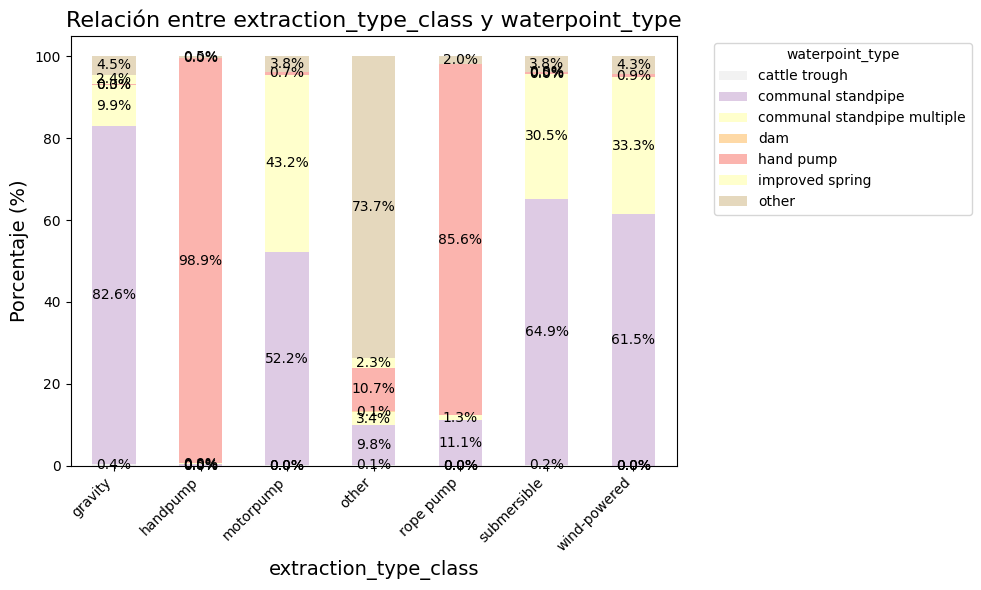


Valores únicos en extraction_type_class: 7
Valores únicos en waterpoint_type: 7
Valor más frecuente en extraction_type_class: gravity
Valor más frecuente en waterpoint_type: communal standpipe

Resultado del análisis chi-cuadrado:
Chi-cuadrado: 90664.9392
P-valor: 0.0000
Grados de libertad: 36
El p-valor es menor que 0.05, por lo que rechazamos la hipótesis nula. Esto indica que extraction_type_class y waterpoint_type están correlacionadas.


In [ ]:
multivariate_analysis(pumps_df,"extraction_type_class" ,"waterpoint_type" )

Es el método más común para "communal standpipe" (grifo comunal), representando el 82.60% de los puntos de agua con este tipo de extracción.

Motorpum es común en "communal standpipe" (52.23%) y "communal standpipe multiple" (43.22%), mostrando su versatilidad.

Extraction_type_class (Clase de tipo de extracción):

- Se refiere a la tecnología o método utilizado para extraer el agua, como bombas manuales, bombas motorizadas, gravedad, entre otros. Básicamente, describe cómo se obtiene el agua de la fuente.

Waterpoint_type (Tipo de punto de agua):

- Este campo describe la infraestructura física en la que el agua es accesible al público o los usuarios. Define el punto final donde la gente accede al agua.